In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sys
sys.path.insert(0, '/home/xhding/workspaces/torch-deep-retina')
import os
import scipy
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyret
from kinetic.evaluation import *
from kinetic.utils import *
from kinetic.config import get_custom_cfg
from kinetic.data import *
from kinetic.notebook.functions import *
import kinetic.models as models
from kinetic.models import *
from torchdeepretina.visualizations import plot_filters

In [9]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'
cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, cfg.Model.name)
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
if checkpoint_path_one_pixel != '':
    checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
    model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
    model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
    try:
        if model.ksr_gain:
            model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
    except:
        pass
model.eval()

KineticsModel(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 8, 1296))
  )
  (kinetics): Kinetics()
  (spiking_block): Sequential(
    (0): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bi

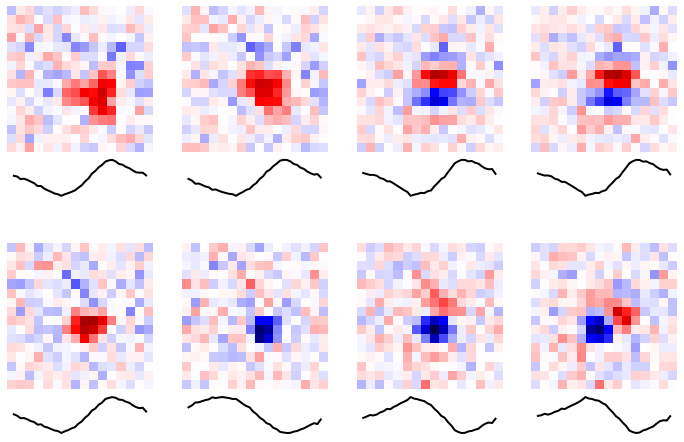

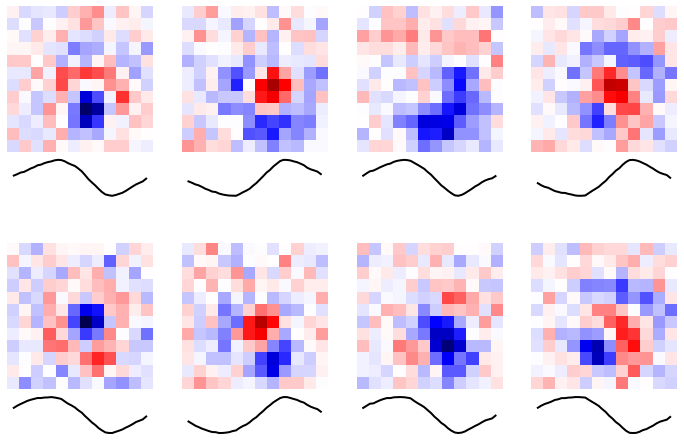

In [12]:
layers = ['bipolar.0', 'amacrine.2']
stas = revcor_sta_rnn(model, layers, device)
fig = plot_filters(np.stack(stas['bipolar.0']), 15)
fig = plot_filters(np.stack(stas['amacrine.2']), 11)

Sensitising Model

In [3]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'
cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, 'KineticsModelSen')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)

In [46]:
model.state_dict().keys()

odict_keys(['kinetics_w', 'kinetics_b', 'kinetics_w_inh', 'kinetics_b_inh', 'bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'bipolar_inh.0.weight', 'bipolar_inh.0.bias', 'kinetics_inh.ka', 'kinetics_inh.kfi', 'kinetics_inh.kfr', 'kinetics_inh.ksi', 'kinetics_inh.ksr', 'kinetics_inh.ksr_2', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinetics.ksr_2', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'ganglion.0.weight'])

In [17]:
checkpoint['model_state_dict'].keys()

odict_keys(['kinetics_w', 'kinetics_b', 'bipolar.0.convs.0.weight', 'bipolar.0.convs.1.weight', 'bipolar.0.convs.2.weight', 'bipolar.0.convs.3.weight', 'bipolar.0.convs.4.weight', 'bipolar.0.convs.5.weight', 'bipolar.0.convs.6.weight', 'bipolar.0.convs.6.bias', 'kinetics.ka', 'kinetics.kfi', 'kinetics.kfr', 'kinetics.ksi', 'kinetics.ksr', 'kinetics.ksr_2', 'amacrine.1.convs.0.weight', 'amacrine.1.convs.1.weight', 'amacrine.1.convs.2.weight', 'amacrine.1.convs.3.weight', 'amacrine.1.convs.4.weight', 'amacrine.1.convs.4.bias', 'ganglion.0.weight'])

In [5]:
state_dict = model.state_dict()
for key in checkpoint['model_state_dict'].keys():
    state_dict[key] = checkpoint['model_state_dict'][key]
    if 'kinetics.' in key:
        state_dict[key[:8]+'_inh'+key[8:]] = checkpoint['model_state_dict'][key]
model.load_state_dict(state_dict)
checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
model.kinetics_inh.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
model.kinetics_inh.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']

try:
    if model.ksr_gain:
        #model.kinetics.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
        #model.kinetics_inh.ksr_2.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr_2']
        pass
except:
    pass

model.eval()

KineticsModelSen(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Reshape(shape=(-1, 8, 1296))
    (2): ScaleShift(shape=(8, 1), scale=True, shift=True)
  )
  (bipolar_nl): Sigmoid()
  (bipolar_inh): Sequential(
    (0): Conv2d(40, 1, kernel_size=(15, 15), stride=(1, 1))
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 1, 1296))
  )
  (kinetics_inh): Kinetics()
  (kinetics): Kinetics()
  (spiking_block1): ReL

In [375]:
model.kinetics_inh.ksi.data = 8.31 * torch.ones(1,1).to(device)
model.kinetics_inh.ksr.data = 0.14 * torch.ones(1,1).to(device)
model.kinetics_inh.ka.data = 20 * torch.ones(1,1).to(device)
model.kinetics_inh.kfi.data = 46.7 * torch.ones(1,1).to(device)
model.kinetics_inh.kfr.data = 79.2 * torch.ones(1,1).to(device)
I20 = [None, np.array([1.04])]

conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(checkpoint['model_state_dict']['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
weight = LinearStack(conv_weights)

tem_filter = weight.mean(0).sum(axis=(-1,-2)) - weight.mean(0).sum(axis=(-1,-2)).mean()
tem_filter /= 200.

x, y = np.meshgrid(np.linspace(-1,1,15), np.linspace(-1,1,15))
dst = np.sqrt(x*x+y*y)
sigma = 0.9
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )

conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.bipolar_inh[0].weight.data = torch.from_numpy(conv_filter).to(device)
model.bipolar_inh[0].bias.data = -4 * torch.ones(1).to(device)

model.bipolar[0].convs[6].bias.data = -2 * torch.ones(8).to(device)
model.kinetics_w_inh.data = 30 * torch.ones(1).to(device)
model.kinetics_b_inh.data = 0 * torch.ones(1).to(device)

In [381]:
import torchdeepretina.stimuli as stim
model.float()
c1 = 0.35
c0 = 0.2
nsamples = 3000
duration=1000
delay=1000
filt_depth = 40
nrepeats = 100
insp_keys = ['bipolar_inh.0', 'bipolar_inh', 'bipolar', 'bipolar_nl', 'spiking_block1', 'kinetics', 'kinetics_inh']
envelope = stim.flash(duration, delay, nsamples, intensity=(c1 - c0))
envelope += c0
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*envelope.shape) * envelope + 1
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.concat(x, nh=filt_depth)).to(device)

        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy().mean(-1) for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy().mean(-1) for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

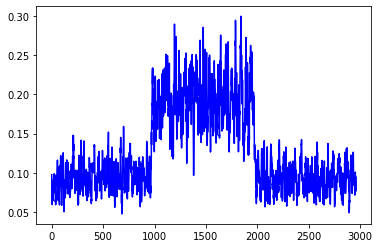

In [401]:
plt.plot(layer_outs['bipolar_inh'][:,0,0],'b')

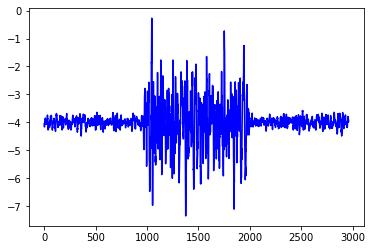

In [203]:
plt.plot(layer_outs['bipolar_inh.0'][:,0,0,0],'b')

In [145]:
np.abs(weight[6]).sum()

157.86491729139732

In [138]:
np.abs(model.bipolar_inh[0].weight.data.cpu().numpy()).sum()

3090.4946

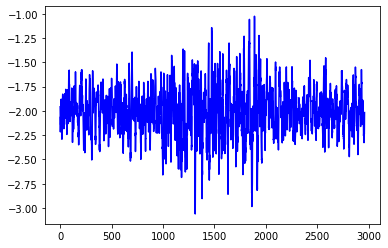

In [402]:
plt.plot(layer_outs['bipolar'][:,0,0], 'b')

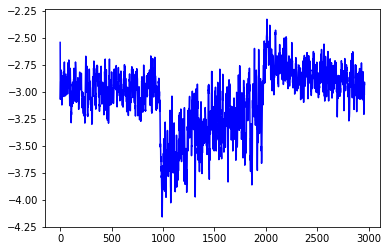

In [403]:
plt.plot(layer_outs['bipolar'][:,0,0] - layer_outs['spiking_block1'][:, 0, 0], 'b')

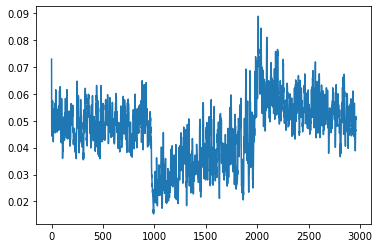

In [404]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
plt.plot(sigmoid(layer_outs['bipolar'][:,0,0] - layer_outs['spiking_block1'][:, 0, 0]))

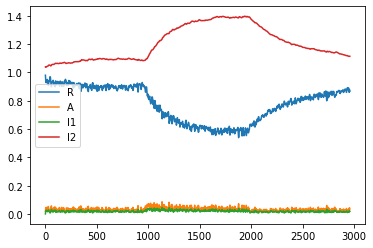

In [318]:
filter_len = 40
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics_inh'][:, 0, 0], label='R')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics_inh'][:, 1, 0], label='A')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics_inh'][:, 2, 0], label='I1')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics_inh'][:, 3, 0], label='I2')
plt.legend()
plt.show()

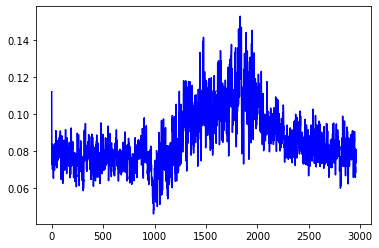

In [405]:
plt.plot(layer_outs['bipolar_nl'][:,0,0], 'b')

In [232]:
print(model.kinetics_inh.kfi.data, model.kinetics_inh.kfr.data, model.kinetics_inh.ka.data)

tensor([[46.7219]], device='cuda:2') tensor([[79.1560]], device='cuda:2') tensor([[22.2559]], device='cuda:2')


In [292]:
kfi = 46.7
kfr = 79.2
ka = 20
u_l = layer_outs['bipolar_inh'][-1000:,0,0].mean()
u_h = layer_outs['bipolar_inh'][-2000:-1000,0,0].mean()
decay_rate = 0.5
A_l = 0.0335
A_h = 0.0621 - 0.02
slow_parameters_solver(A_l, A_h, decay_rate, kfi, kfr, ka, u_l, u_h)

(8.306749628578014, 0.14042706128744584, 1.0419124300417355)

In [294]:
As = layer_outs['kinetics_inh'][:, 1, 0]
(As[:960].mean() + As[1960:].mean())/2, As[960:1960].mean()

(0.06024773418903351, 0.108843766)

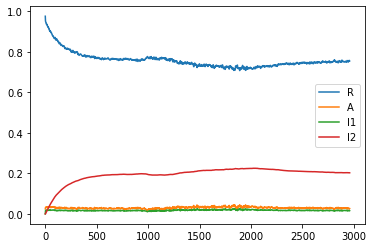

In [406]:
filter_len = 40
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 0, 0], label='R')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 1, 0], label='A')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 2, 0], label='I1')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 3, 0], label='I2')
plt.legend()
plt.show()

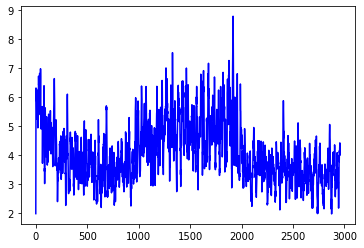

In [407]:
plt.plot(layer_outs['outputs'][:,0], 'b')

In [439]:
low_contrast = 0.2
high_contrast = 0.35
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

In [479]:
nrepeats = 100
insp_keys = ['bipolar_inh.0', 'bipolar_inh', 'bipolar', 'bipolar_nl', 'spiking_block1', 'kinetics', 'kinetics_inh', 'spiking_block2']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy().mean(-1) for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy().mean(-1) for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

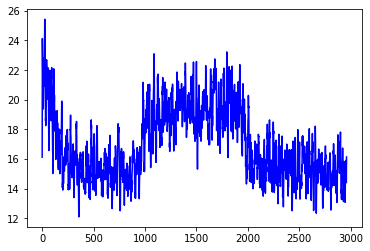

In [476]:
plt.plot(layer_outs['outputs'][:,0], 'b')

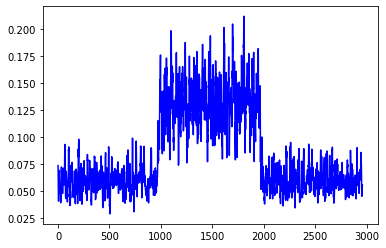

In [467]:
plt.plot(layer_outs['bipolar_inh'][:,0,666],'b')

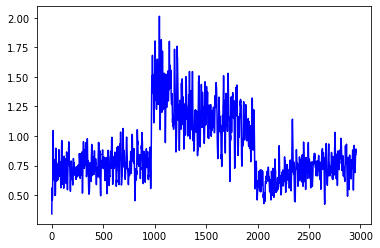

In [486]:
plt.plot(layer_outs['spiking_block1'][:, 0, 666], 'b')

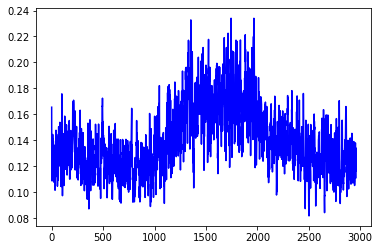

In [489]:
plt.plot(layer_outs['bipolar_nl'][:,0,666],'b')

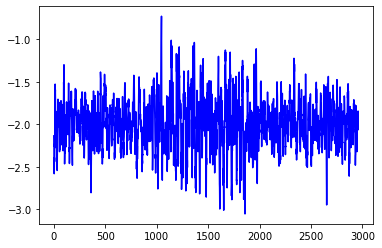

In [493]:
plt.plot(layer_outs['bipolar'][:,0,666],'b')

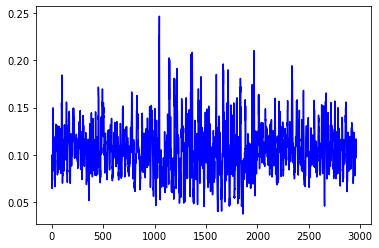

In [503]:
plt.plot(sigmoid(layer_outs['bipolar'][:,0,666]-0.2*layer_outs['spiking_block1'][:, 0, 666]),'b')

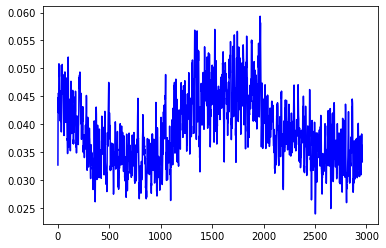

In [485]:
plt.plot(layer_outs['spiking_block2'][:, 0, 666], 'b')

In [273]:
model.kinetics_inh.ksi.data = 8.31 * torch.ones(1,1).to(device)
model.kinetics_inh.ksr.data = 0.14 * torch.ones(1,1).to(device)
model.kinetics_inh.ka.data = 20 * torch.ones(1,1).to(device)
model.kinetics_inh.kfi.data = 46.7 * torch.ones(1,1).to(device)
model.kinetics_inh.kfr.data = 79.2 * torch.ones(1,1).to(device)
model.kinetics.ksr_2.data = 0. * torch.ones(1,1).to(device)
I20 = [None, np.array([1.04])]

conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(checkpoint['model_state_dict']['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
weight = LinearStack(conv_weights)

tem_filter = weight.mean(0).sum(axis=(-1,-2)) - weight.mean(0).sum(axis=(-1,-2)).mean()
tem_filter /= 200.

x, y = np.meshgrid(np.linspace(-1,1,15), np.linspace(-1,1,15))
dst = np.sqrt(x*x+y*y)
sigma = 0.9
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )

conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.bipolar_inh[0].weight.data = torch.from_numpy(conv_filter).to(device)
model.bipolar_inh[0].bias.data = -4 * torch.ones(1).to(device)

model.kinetics_w_inh.data = 15 * torch.tensor([ 1., 1., 1., 1., 1., 1., 1., 1.])[:,None].to(device)
model.kinetics_b_inh.data = 0 * torch.ones(8,1).to(device)
model.bipolar[0].convs[6].bias.data = 0 * torch.ones(8).to(device)
#model.bipolar[0].convs[6].bias.data = -4 * torch.ones(8).to(device)
model.bipolar[2].scale_param.data = torch.tensor([ 1., 1./12, 1., 1./4, 1./1.7, 1./10, 1./10, 1./6])[:,None].to(device)
model.bipolar[2].shift_param.data = -4 * torch.ones(8,1).to(device)

In [274]:
low_contrast = 0.2
high_contrast = 0.7
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

model.float()
nrepeats = 50
insp_keys = ['bipolar', 'bipolar_nl', 'spiking_block1', 'kinetics', 'spiking_block2', 'amacrine']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

In [193]:
(layer_outs['spiking_block1'][:960, 0, 670].mean() + layer_outs['spiking_block1'][-1000:, 0, 670].mean())/2

0.30914485454559326

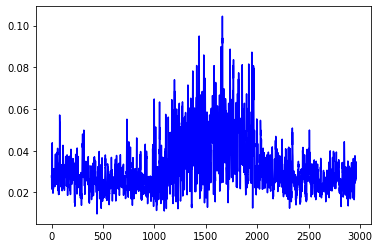

In [11]:
plt.plot(layer_outs['bipolar_nl'][:, 0, 671], 'b')

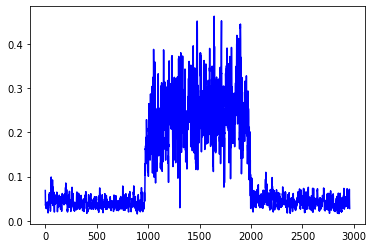

In [112]:
plt.plot(layer_outs['bipolar_nl'][:, 0, 670], 'b')

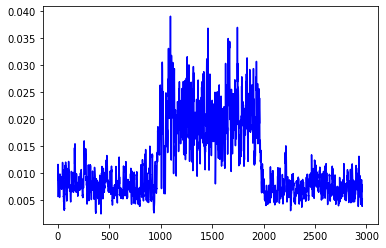

In [298]:
plt.plot(layer_outs['spiking_block2'][:, 2, 666], 'b')

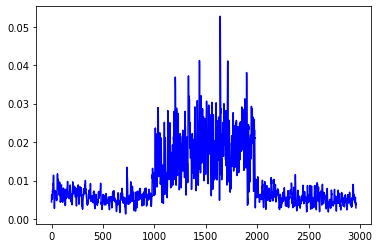

In [114]:
plt.plot(layer_outs['spiking_block2'][:, 0, 670], 'b')

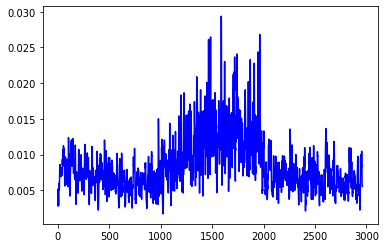

In [456]:
plt.plot(layer_outs['spiking_block2'][:, 0, 671], 'b')

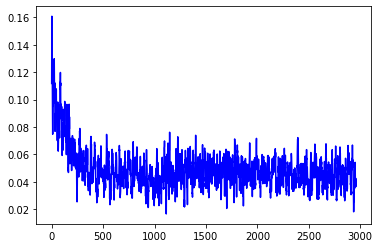

In [42]:
plt.plot(layer_outs['spiking_block2'][:, 1, 671], 'b')

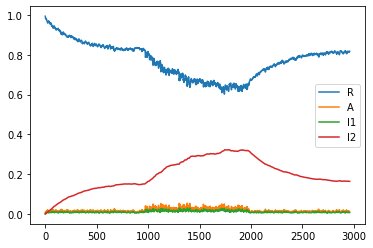

In [73]:
channel = 2
filter_len = 40
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 0, channel, 666], label='R')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 1, channel, 666], label='A')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 2, channel, 666], label='I1')
plt.plot(np.arange(3000 - filter_len),layer_outs['kinetics'][:, 3, channel, 666], label='I2')
plt.legend()
plt.show()

In [27]:
layer_outs['bipolar'][:,:,666].std(axis=0)/layer_outs['bipolar'][:,0,666].std()

array([ 1.0000005, 11.703224 ,  0.4350787,  2.966004 ,  1.0635973,
        1.4432199,  1.3394562,  0.6275026], dtype=float32)

In [28]:
layer_outs['bipolar'][:,:,671].std(axis=0)/layer_outs['bipolar'][:,0,671].std()

array([ 0.9999995 , 11.887354  ,  0.82039803,  3.6800346 ,  1.1643633 ,
        1.3164368 ,  1.6752636 ,  2.515242  ], dtype=float32)

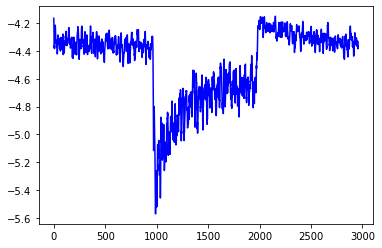

In [217]:
plt.plot(layer_outs['bipolar'][:,7,666] - layer_outs['spiking_block1'][:,7,666],'b')

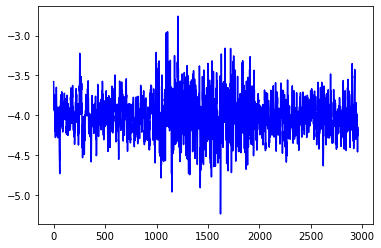

In [282]:
plt.plot(layer_outs['bipolar'][:,2,670],'b')

In [299]:
layer_outs['spiking_block2'][:, :, 666].mean(0)

array([0.02208905, 0.02140769, 0.01171006, 0.01724216, 0.01397966,
       0.00327727, 0.00291293, 0.00218426], dtype=float32)

In [300]:
model.kinetics_inh.ksi.data = 8.31 * torch.ones(1,1).to(device)
model.kinetics_inh.ksr.data = 0.14 * torch.ones(1,1).to(device)
model.kinetics_inh.ka.data = 20 * torch.ones(1,1).to(device)
model.kinetics_inh.kfi.data = 46.7 * torch.ones(1,1).to(device)
model.kinetics_inh.kfr.data = 79.2 * torch.ones(1,1).to(device)
model.kinetics.ksr_2.data = 0. * torch.ones(1,1).to(device)
I20 = [None, np.array([1.04])]

conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(checkpoint['model_state_dict']['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
weight = LinearStack(conv_weights)

tem_filter = weight.mean(0).sum(axis=(-1,-2)) - weight.mean(0).sum(axis=(-1,-2)).mean()
tem_filter /= 200.

x, y = np.meshgrid(np.linspace(-1,1,15), np.linspace(-1,1,15))
dst = np.sqrt(x*x+y*y)
sigma = 0.9
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )

conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.bipolar_inh[0].weight.data = torch.from_numpy(conv_filter).to(device)
model.bipolar_inh[0].bias.data = -4 * torch.ones(1).to(device)

model.kinetics_w_inh.data = 0 * torch.tensor([ 1., 1., 1., 1., 1., 1., 1., 1.])[:,None].to(device)
model.kinetics_b_inh.data = 0 * torch.ones(8,1).to(device)
model.bipolar[0].convs[6].bias.data = 0 * torch.ones(8).to(device)
#model.bipolar[0].convs[6].bias.data = -4 * torch.ones(8).to(device)
model.bipolar[2].scale_param.data = torch.ones(8,1).to(device)
model.bipolar[2].shift_param.data = -4 * torch.ones(8,1).to(device)

In [301]:
low_contrast = 0.2
high_contrast = 0.7
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

model.float()
nrepeats = 50
insp_keys = ['bipolar', 'bipolar_nl', 'spiking_block1', 'kinetics', 'spiking_block2', 'amacrine']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

In [302]:
layer_outs['spiking_block2'][:, :, 666].mean(0)

array([0.02876047, 0.05379498, 0.01644395, 0.04687465, 0.02998026,
       0.03576004, 0.0339333 , 0.01986429], dtype=float32)

In [304]:
np.array([0.02876047, 0.05379498, 0.01644395, 0.04687465, 0.02998026, 0.03576004, 0.0339333, 0.01986429])/ np.array([0.02208905, 0.02140769, 0.01171006, 0.01724216, 0.01397966, 0.00327727, 0.00291293, 0.00218426])

array([ 1.30202385,  2.51288112,  1.40425839,  2.7186066 ,  2.14456289,
       10.91153307, 11.64919857,  9.09428823])

In [309]:
model.kinetics_inh.ksi.data = 8.31 * torch.ones(1,1).to(device)
model.kinetics_inh.ksr.data = 0.14 * torch.ones(1,1).to(device)
model.kinetics_inh.ka.data = 20 * torch.ones(1,1).to(device)
model.kinetics_inh.kfi.data = 46.7 * torch.ones(1,1).to(device)
model.kinetics_inh.kfr.data = 79.2 * torch.ones(1,1).to(device)
model.kinetics.ksr_2.data = 0. * torch.ones(1,1).to(device)
I20 = [None, np.array([1.04])]

conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(checkpoint['model_state_dict']['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
weight = LinearStack(conv_weights)

tem_filter = weight.mean(0).sum(axis=(-1,-2)) - weight.mean(0).sum(axis=(-1,-2)).mean()
tem_filter /= 200.

x, y = np.meshgrid(np.linspace(-1,1,15), np.linspace(-1,1,15))
dst = np.sqrt(x*x+y*y)
sigma = 0.9
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )

conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.bipolar_inh[0].weight.data = torch.from_numpy(conv_filter).to(device)
model.bipolar_inh[0].bias.data = -4 * torch.ones(1).to(device)

model.kinetics_w_inh.data = 15 * torch.tensor([ 1., 1., 1., 1., 1., 1., 1., 1.])[:,None].to(device)
model.kinetics_b_inh.data = 0 * torch.ones(8,1).to(device)
model.bipolar[0].convs[6].bias.data = 0 * torch.ones(8).to(device)
#model.bipolar[0].convs[6].bias.data = -4 * torch.ones(8).to(device)
model.bipolar[2].scale_param.data = torch.tensor([ 1., 1./12, 1., 1./4, 1./1.7, 1./10, 1./10, 1./6])[:,None].to(device)
model.bipolar[2].shift_param.data = -4 * torch.ones(8,1).to(device)

model.kinetics_w.data = torch.tensor([1.30202385, 2.51288112, 1.40425839, 2.7186066, 2.14456289, 10.91153307, 11.64919857, 9.09428823])[:,None].to(device)
model.kinetics_b.data = 0 * torch.ones(8,1).to(device)

In [310]:
low_contrast = 0.2
high_contrast = 0.7
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

model.float()
nrepeats = 50
insp_keys = ['bipolar', 'bipolar_nl', 'spiking_block1', 'kinetics', 'spiking_block2', 'amacrine']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

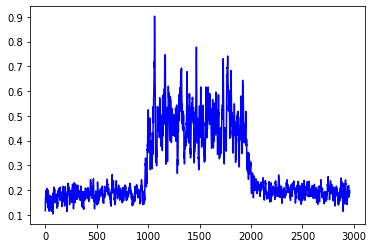

In [315]:
plt.plot(layer_outs['amacrine'].reshape((-1,8,26,26))[:,0,13,13], 'b')

In [332]:
linear_weights = model.ganglion[0].weight.data.cpu().numpy().reshape((4,8,26,26))

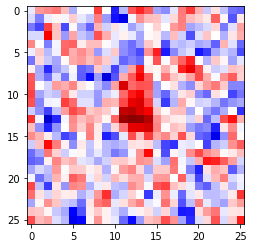

In [392]:
plt.imshow(linear_weights.mean(1)[0], vmax=0.3, vmin=-0.3, cmap='seismic')

In [378]:
linear_weights.mean(1).min()

-0.20030262

In [401]:
gauss.sum()

14.131831208276104

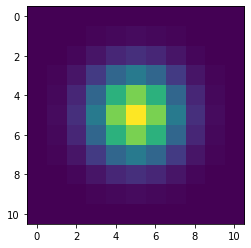

In [393]:
x, y = np.meshgrid(np.linspace(-1,1,11), np.linspace(-1,1,11))
dst = np.sqrt(x*x+y*y)
sigma = 0.3
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )
plt.imshow(gauss)

In [3]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_both/epoch_045_loss_-60.15_pearson_natural_0.4562_pearson_noise_0.4354.pth'
checkpoint_path_one_pixel = '/home/xhding/saved_model/kinetics_one_pixel/epoch_005_loss_1.46_pearson_0.4466.pth'
cfg_name = 'kinetics_both'
cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, 'KineticsModelSenConv')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)

state_dict = model.state_dict()
for key in checkpoint['model_state_dict'].keys():
    if 'ganglion' in key:
        continue
    state_dict[key] = checkpoint['model_state_dict'][key]
    if 'kinetics.' in key:
        state_dict[key[:8]+'_inh'+key[8:]] = checkpoint['model_state_dict'][key]

model.load_state_dict(state_dict)
checkpoint_one_pixel = torch.load(checkpoint_path_one_pixel, map_location=device)
model.kinetics.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
model.kinetics.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']
model.kinetics_inh.ksi.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksi']
model.kinetics_inh.ksr.data = checkpoint_one_pixel['model_state_dict']['kinetics.ksr']

model.eval()

KineticsModelSenConv(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Reshape(shape=(-1, 8, 1296))
    (2): ScaleShift(shape=(8, 1), scale=True, shift=True)
  )
  (bipolar_nl): Sigmoid()
  (bipolar_inh): Sequential(
    (0): Conv2d(40, 1, kernel_size=(15, 15), stride=(1, 1))
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 1, 1296))
  )
  (kinetics_inh): Kinetics()
  (kinetics): Kinetics()
  (spiking_block1):

In [130]:
model.kinetics_inh.ksi.data = 8.31 * torch.ones(1,1).to(device)
model.kinetics_inh.ksr.data = 0.14 * torch.ones(1,1).to(device)
model.kinetics_inh.ka.data = 20 * torch.ones(1,1).to(device)
model.kinetics_inh.kfi.data = 46.7 * torch.ones(1,1).to(device)
model.kinetics_inh.kfr.data = 79.2 * torch.ones(1,1).to(device)
model.kinetics.ksr_2.data = 0. * torch.ones(1,1).to(device)
I20 = [None, np.array([1.04])]

conv_weights = []
for i in range((cfg.Model.ksizes[0]-1)//2):
    conv_weights.append(checkpoint['model_state_dict']['bipolar.0.convs.{}.weight'.format(i)].cpu().numpy())
weight = LinearStack(conv_weights)

tem_filter = weight.mean(0).sum(axis=(-1,-2)) - weight.mean(0).sum(axis=(-1,-2)).mean()
tem_filter /= 200.

x, y = np.meshgrid(np.linspace(-1,1,15), np.linspace(-1,1,15))
dst = np.sqrt(x*x+y*y)
sigma = 0.9
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )

conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.bipolar_inh[0].weight.data = torch.from_numpy(conv_filter).to(device)
model.bipolar_inh[0].bias.data = -4 * torch.ones(1).to(device)

model.kinetics_w_inh.data = 1.5 * torch.tensor([ 1., 1., 1., 1., 1., 1., 1., 1.])[:,None].to(device)
model.kinetics_b_inh.data = 0 * torch.ones(8,1).to(device)
model.bipolar[0].convs[6].bias.data = 0 * torch.ones(8).to(device)
#model.bipolar[0].convs[6].bias.data = -4 * torch.ones(8).to(device)
model.bipolar[2].scale_param.data = torch.tensor([ 1., 1./12, 1., 1./4, 1./1.7, 1./10, 1./10, 1./6])[:,None].to(device)
model.bipolar[2].shift_param.data = -4 * torch.ones(8,1).to(device)

model.kinetics_w.data = torch.tensor([1.30202385, 2.51288112, 1.40425839, 2.7186066, 2.14456289, 10.91153307, 11.64919857, 9.09428823])[:,None].to(device)
model.kinetics_b.data = 0 * torch.ones(8,1).to(device)

x, y = np.meshgrid(np.linspace(-1,1,11), np.linspace(-1,1,11))
dst = np.sqrt(x*x+y*y)
sigma = 0.3
gauss = np.exp(-( dst**2 / ( 2.0 * sigma**2 ) ) )
tem_filter = np.array([1.,0,0,0,0,0,0,0])
conv_filter = np.expand_dims(tem_filter, axis=(0, -1, -2)) * gauss
model.ganglion[0].weight.data = torch.from_numpy(conv_filter).to(device)

In [131]:
low_contrast = 0.2
high_contrast = 0.7
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

model.float()
nrepeats = 100
insp_keys = ['kinetics', 'spiking_block2', 'amacrine', 'ganglion']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

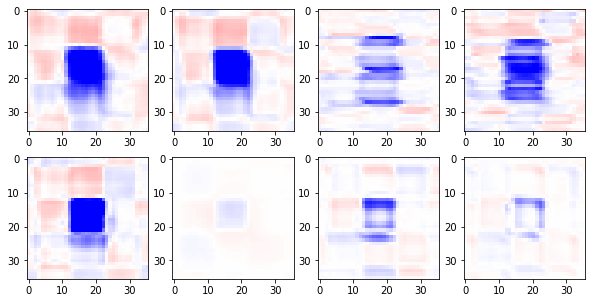

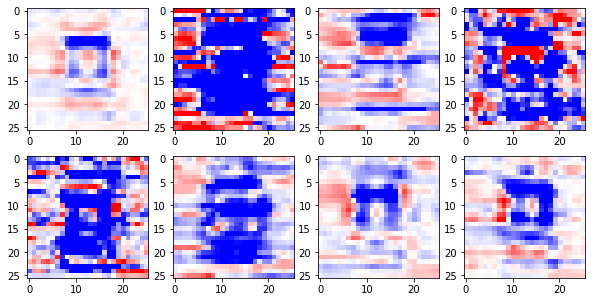

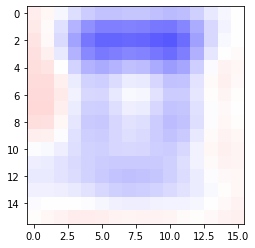

In [132]:
adaptive_index_bipolar(layer_outs)
adaptive_index_amacrine(layer_outs)
adaptive_index_ganglion(layer_outs)

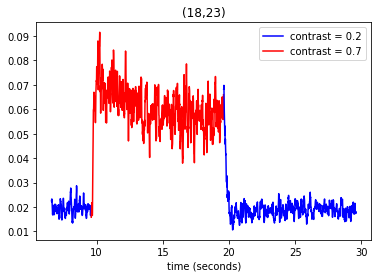

In [116]:
response = layer_outs['spiking_block2'].reshape((-1,8,36,36))[:,0,18,18]
plt.plot(np.arange(660,960)/100, response[660:960],'b', label='contrast = 0.2')
plt.plot(np.arange(960,1960)/100, response[960:1960],'r', label='contrast = 0.7')
plt.plot(np.arange(1960,2960)/100, response[1960:2960],'b')
plt.xlabel('time (seconds)')
plt.title('(18,23)')
plt.legend()

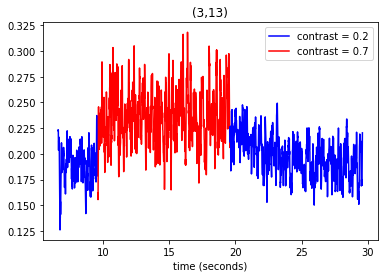

In [76]:
response = layer_outs['amacrine'].reshape((-1,8,26,26))[:,0,3,13]
plt.plot(np.arange(660,960)/100, response[660:960],'b', label='contrast = 0.2')
plt.plot(np.arange(960,1960)/100, response[960:1960],'r', label='contrast = 0.7')
plt.plot(np.arange(1960,2960)/100, response[1960:2960],'b')
plt.xlabel('time (seconds)')
plt.title('(3,13)')
plt.legend()

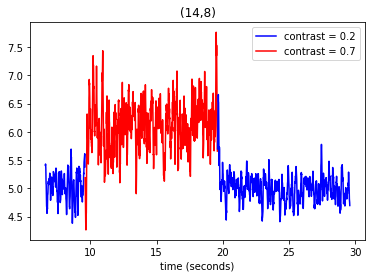

In [100]:
response = layer_outs['ganglion'].reshape((-1,16,16))[:,14,8]
plt.plot(np.arange(660,960)/100, response[660:960],'b', label='contrast = 0.2')
plt.plot(np.arange(960,1960)/100, response[960:1960],'r', label='contrast = 0.7')
plt.plot(np.arange(1960,2960)/100, response[1960:2960],'b')
plt.xlabel('time (seconds)')
plt.title('(14,8)')
plt.legend()

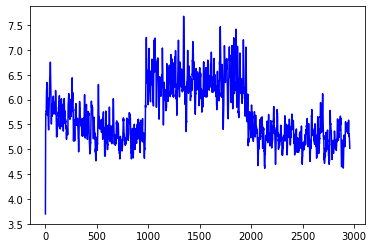

In [638]:
plt.plot(layer_outs['ganglion'][:,0,1,14], 'b')

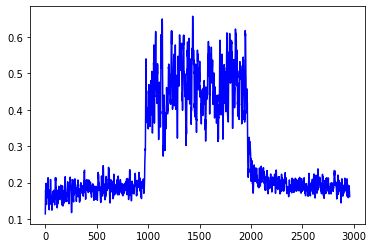

In [647]:
plt.plot(layer_outs['amacrine'].reshape((-1,8,26,26))[:,0,13,13], 'b')

In [653]:
model.kinetics.ksi

Parameter containing:
tensor([[6.1832]], device='cuda:2', requires_grad=True)

In [139]:
device = torch.device('cuda:2')
checkpoint_path = '/home/xhding/saved_model/kinetics_sen/epoch_025_loss_-97.36_pearson_0.5279.pth'
cfg_name = 'kinetics_sen'
cfg = get_custom_cfg(cfg_name)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_func = getattr(models, 'KineticsModelSen')
model_kwargs = dict(cfg.Model)
model = model_func(**model_kwargs).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

KineticsModelSen(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Reshape(shape=(-1, 8, 1296))
    (2): ScaleShift(shape=(8, 1), scale=True, shift=True)
  )
  (bipolar_nl): Sigmoid()
  (bipolar_inh): Sequential(
    (0): Conv2d(40, 1, kernel_size=(15, 15), stride=(1, 1))
    (1): Sigmoid()
    (2): Reshape(shape=(-1, 1, 1296))
  )
  (kinetics_inh): Kinetics()
  (kinetics): Kinetics()
  (spiking_block1): ReL

In [134]:
low_contrast = 0.2
high_contrast = 0.7
pos_x = 2
pos_y = 2
filt_depth = 40
contrast_env = np.ones((3000, 5, 5)) * low_contrast
contrast_env[1000:2000, pos_x, pos_y] = high_contrast

I20 = [None, np.array([1.04])]

model.float()
nrepeats = 100
insp_keys = ['kinetics', 'spiking_block2', 'amacrine', 'ganglion']
hs_mode = 'double'
layer_outs_list = {key:[] for key in insp_keys}
layer_outs_list['outputs'] = []
with torch.no_grad():
    for _ in range(nrepeats):
        x = np.random.randn(*contrast_env.shape) * contrast_env + 1
        x = np.repeat(x, 10, axis=-1)
        x = np.repeat(x, 10, axis=-2)
        x = (x - x.mean())/x.std()
        x = torch.from_numpy(stim.rolling_window(x, filt_depth, time_axis=0)).float().to(device)
        hs = get_hs(model, 1, device, I20, hs_mode)
        layer_outs = inspect_rnn(model, x, hs, insp_keys)
        for key in layer_outs_list.keys():
            if key == 'kinetics':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            elif key == 'kinetics_inh':
                kinetics_history = [h[1].detach().cpu().numpy() for h in layer_outs['kinetics_inh']]
                kinetics_history = np.concatenate(kinetics_history, axis=0)
                layer_outs_list[key].append(kinetics_history)
            else:
                layer_outs_list[key].append(layer_outs[key])
for key in layer_outs_list.keys():
    if isinstance(layer_outs_list[key][0], np.ndarray):
        layer_outs[key] = np.array(layer_outs_list[key]).mean(0)
    else:
        layer_outs[key] = layer_outs_list[key]

response = layer_outs['outputs']

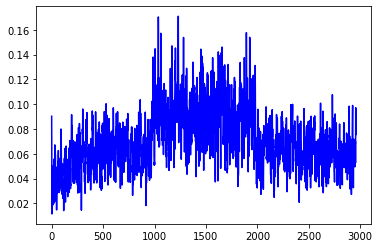

In [112]:
plt.plot(layer_outs['amacrine'].reshape((-1,8,26,26))[:,3,20,13], 'b')

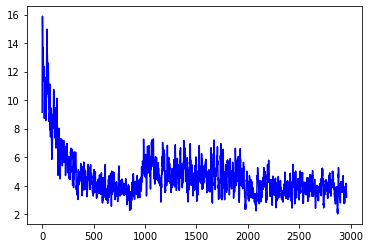

In [90]:
plt.plot(layer_outs['ganglion'][:,3], 'b')

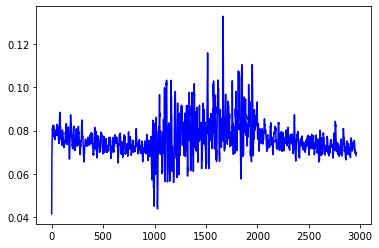

In [155]:
plt.plot(layer_outs['spiking_block2'][:, 5, 660], 'b')

In [159]:
layer_outs['amacrine'].shape

(2960, 5408)

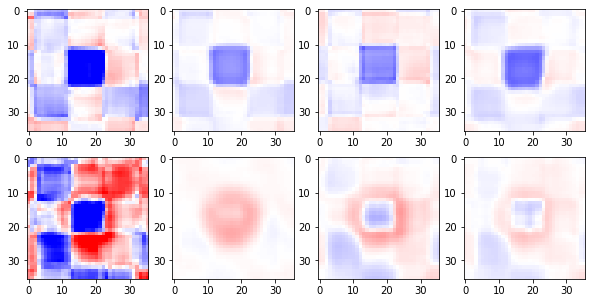

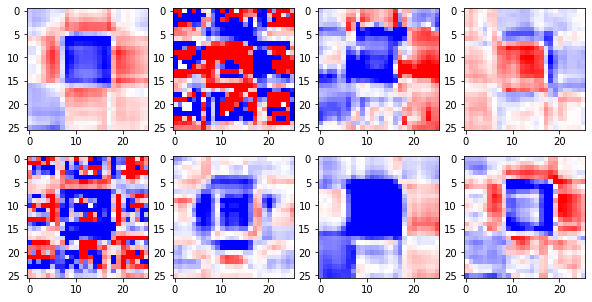

In [135]:
adaptive_index_bipolar(layer_outs)
adaptive_index_amacrine(layer_outs)

In [140]:
data_kwargs = dict(cfg.Data)
train_dataset = MyDataset(stim_sec='train', **data_kwargs)
test_data =  DataLoader(dataset=MyDataset(stim_sec='test', stats=train_dataset.stats, **data_kwargs))
pearsonr_eval(model, test_data, cfg.Model.n_units, device, I20=I20, start_idx=cfg.Data.start_idx, hs_mode=cfg.Data.hs_mode)

0.6787862826346294